Plik, w którym znajduje się kod do trenowania sieci mającej za zadanie przewidywać parametry do retuszu lokalnego, czyli na
posegmentowanych kawałkach zdjęcia.

In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D,Flatten,Dense, Add,Dropout,UpSampling2D,Conv2DTranspose,Activation,Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input
plt.rcParams['figure.figsize']=18,10

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
df_train=pd.read_csv(r"C:\Users\komej\Desktop\AutoEnhancer\values_slices.csv")
df_test=pd.read_csv(r"C:\Users\komej\Desktop\AutoEnhancer\values_slices_test.csv")

Wszystkie etykiety do posegmentowanych zdjęć z wartościami są zapisane w pliku csv. Wszystkie dane są zapisane w taki sposób aby miały mały rozstęp i mieściły się w jednym przedziale liczbowym oraz jak najmniejszą liczbę wartości odstających. Zbiór treningowy jest nieduży, ale będzie stale powiększany.

In [4]:
df_train.head(10)

,Unnamed: 0,Postprocessed,Postprocessed_raw,Whites,Blacks,Exposure,Gamma,Shadows,Highlights,Contrast,Dehaze,Temperature,Saturation,Tint,Denoise,Color_denoise,Sharpen
0,0,/segmented_postprocessed/_DSC0111_1.png,/segmented_imgs/_DSC0111_1.png,1,1,0.10,0.25,0.05,0.12,0.07,0.05,6100,3,2,0.40,0.25,0.20
1,1,/segmented_postprocessed/_DSC0111_2.png,/segmented_imgs/_DSC0111_2.png,-5,2,0.95,-0.10,0.05,0.10,0.07,0.00,6000,-3,-2,0.40,0.25,0.20
2,2,/segmented_postprocessed/_DSC0111_3.png,/segmented_imgs/_DSC0111_3.png,3,-1,0.18,0.15,0.05,0.07,0.11,0.20,6300,1,-1,0.30,0.20,0.15
3,3,/segmented_postprocessed/_DSC0111_6.png,/segmented_imgs/_DSC0111_6.png,1,-1,0.15,0.10,0.00,0.07,0.15,0.10,6100,5,-1,0.30,0.25,0.15
4,4,/segmented_postprocessed/_DSC0120_1.png,/segmented_imgs/_DSC0120_1.png,-1,-1,0.10,0.11,0.00,0.09,0.05,0.15,6100,4,-1,0.40,0.20,0.15
5,5,/segmented_postprocessed/_DSC0120_4.png,/segmented_imgs/_DSC0120_4.png,-1,-1,0.07,0.15,0.02,0.10,0.07,0.10,6200,6,1,0.35,0.20,0.17
6,6,/segmented_postprocessed/_DSC0120_6.png,/segmented_imgs/_DSC0120_6.png,0,0,0.10,0.10,0.02,0.05,0.07,0.10,6400,7,-1,0.35,0.20,0.17
7,7,/segmented_postprocessed/_DSC0128_1.png,/segmented_imgs/_DSC0128_1.png,0,-1,0.08,0.15,0.02,0.06,0.20,0.04,6600,0,4,0.45,0.20,0.10
8,8,/segmented_postprocessed/_DSC0128_3.png,/segmented_imgs/_DSC0128_3.png,0,-1,0.15,0.10,0.05,0.03,0.09,0.15,6200,1,-1,0.35,0.10,0.15
9,9,/segmented_postprocessed/_DSC0128_4.png,/segmented_imgs/_DSC0128_4.png,0,-1,0.10,0.10,0.05,0.08,0.07,0.10,6400,5,1,0.35,0.10,0.15


In [5]:
del df_train['Unnamed: 0']

In [6]:
df_train.describe()

,Whites,Blacks,Exposure,Gamma,Shadows,Highlights,Contrast,Dehaze,Temperature,Saturation,Tint,Denoise,Color_denoise,Sharpen
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,-0.211538,-0.153846,0.128077,0.099615,0.026154,0.066154,0.088462,0.110000,6480.769231,3.230769,0.211538,0.262500,0.125577,0.114808
std,1.035385,0.638153,0.215580,0.064594,0.030367,0.025907,0.035112,0.108139,409.705041,2.025479,1.446247,0.104654,0.044255,0.045697
min,-5.000000,-1.000000,0.000000,-0.100000,0.000000,0.030000,0.030000,0.000000,6000.000000,-3.000000,-2.000000,0.100000,0.100000,0.010000
25%,-1.000000,-0.250000,0.030000,0.070000,0.000000,0.050000,0.067500,0.050000,6300.000000,2.000000,-1.000000,0.200000,0.100000,0.100000
50%,0.000000,0.000000,0.070000,0.100000,0.020000,0.070000,0.095000,0.100000,6400.000000,3.000000,1.000000,0.250000,0.100000,0.100000
75%,0.000000,0.000000,0.100000,0.150000,0.050000,0.082500,0.100000,0.100000,6600.000000,5.000000,1.000000,0.350000,0.150000,0.150000
max,3.000000,2.000000,0.970000,0.250000,0.100000,0.120000,0.200000,0.600000,8000.000000,8.000000,4.000000,0.500000,0.250000,0.220000


Architektura sieci klasyfikatora to ponownie, przetrenowana sieć VGG16. Ta sieć bardzo dobrze się sprawdza w tego typuzadaniach, gdyż przez swoją prostą architekturę z dużą ilością filtrów ma bardzo dobre zdolności percepcyjne. Pomimo słabszego wyniku dokładności niż inne architektury np. Xception, ResNet, DenseNet, itp. w tym zadaniu sprawdza się od nich znacznie lepiej, wychwytuje ważne szczegóły oraz wiele istotnych cech percepcyjnych z obrazu. Model na wejściu przyjmuje dane(zdjęcia) o zmiennych wymiarach. Po serii warstw konwolucji, jest warstwa uśredniająca GlobalAveragePooling2D, po niej warstwa Dense z 1024 filtrami, aby sieć była wystarczająco skuteczna. Model ma 14 wyjść, tak samo jak w modelu do retuszu globalnego.

In [7]:
vgg16=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(None,None,3))

x=GlobalAveragePooling2D()(vgg16.output)
x=Dense(1024,activation='relu')(x)

whites=Dense(1,name='whites')(x)
blacks=Dense(1,name='blacks')(x)
exposure=Dense(1,name='exposure')(x)
gamma=Dense(1,name='gamma')(x)
shadows=Dense(1,name='shadows')(x)
highlights=Dense(1,name='highlights')(x)
contrast=Dense(1,name='contrast')(x)
dehaze=Dense(1,name='dehaze')(x)
temp=Dense(1,name='temp')(x)
sat=Dense(1,name='sat')(x)
tint=Dense(1,name='tint')(x)
denoise=Dense(1,name='denoise')(x)
color=Dense(1,name='color')(x)
sharpen=Dense(1,name='sharpen')(x)

model=Model(vgg16.input,[whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen])

Sieć skompilowana jest optymalizatorem Adam z początkową szybkością uczenia 1e-4, funkcje kosztu to głównie błąd średniokwadratowy(MSE).

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss={'whites':'mse','blacks':'mse','exposure':'mse','gamma':'mse','shadows':'mse','highlights':'mse','contrast':'mse','dehaze':'mae','temp':'mse','sat':'mse','tint':'mse','denoise':'mse','color':'mse','sharpen':'mse'})

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

                                                                                                  
 sat (Dense)                    (None, 1)            1025        ['dense[0][0]']                  
                                                                                                  
 tint (Dense)                   (None, 1)            1025        ['dense[0][0]']                  
                                                                                                  
 denoise (Dense)                (None, 1)            1025        ['dense[0][0]']                  
                                                                                                  
 color (Dense)                  (None, 1)            1025        ['dense[0][0]']                  
                                                                                                  
 sharpen (Dense)                (None, 1)            1025        ['dense[0][0]']                  
          

In [10]:
#Funkcja do przycięcia zdjęcia ze zbędnych pustych wartości 0.
def crop_img(img):
    indx=np.where(img>0)
    indx=np.array(indx)
    px_coords=list(zip(indx[0],indx[1]))
    px_coords=np.array(px_coords)
    y=px_coords[:,0]
    x=px_coords[:,1]
    ymin=y.min()
    ymax=y.max()
    xmin=x.min()
    xmax=x.max()
    crop=img[ymin:ymax,xmin:xmax]
    return crop

In [16]:
#Funkcja losowo wczytująca zdjęcia oraz etykiety do procesu trenowania sieci oraz odpowiednio je przetwarza 
def batch_gen(batch_size,df):
    while(1):
        path='C:/Users/komej/Desktop/AutoEnhancer/'
        batches=df.sample(n=batch_size)
        img_files=batches['Postprocessed_raw']
        img_arr=[]
        for i in img_files:
            img_arr.append(i)
        whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen=batches['Whites'],batches['Blacks'],batches['Exposure'],batches['Gamma'],batches['Shadows'],batches['Highlights'],batches['Contrast'],batches['Dehaze'],batches['Temperature'],batches['Saturation'], batches['Tint'],batches['Denoise'],batches['Color_denoise'],batches['Sharpen']
        #Skalowanie danych do tego samego zakresu
        whites=whites/10
        blacks=blacks/10
        temp=temp/10000
        sat=sat/10
        tint=tint/10
        images=[]
        for img in img_arr:
            img_train=cv2.imread(path+img)
            img_train=crop_img(img_train)
            images.append(img_train)
        images=np.array(images,dtype=np.float32)
        preprocessed_images=preprocess_input(images)/127.5
        yield(preprocessed_images,[np.array(whites),np.array(blacks),np.array(exposure),np.array(gamma),np.array(shadows),np.array(highlights),np.array(contrast),
                                   np.array(dehaze),np.array(temp),np.array(sat),np.array(tint),np.array(denoise),
                                   np.array(color),np.array(sharpen)])

In [17]:
#Funkcja umożliwiająca szacowanie skuteczności sieci podczas trenowania, wczytuje zbiór testowy
def test_gen(df):
    path='C:/Users/komej/Desktop/AutoEnhancer/'
    files=df['Postprocessed_raw']
    arr=[]
    for i in files:
        arr.append(i)
    whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen=df['Whites'],df['Blacks'],df['Exposure'],df['Gamma'],df['Shadows'],df['Highlights'],df['Contrast'],df['Dehaze'],df['Temperature'],df['Saturation'], df['Tint'],df['Denoise'],df['Color_denoise'],df['Sharpen']
    #Skalowanie danych do tego samego zakresu
    whites=whites/10
    blacks=blacks/10
    temp=temp/10000
    sat=sat/10
    tint=tint/10
    images=[]
    for img in arr:
        img_train=cv2.imread(path+img)
        img_train=crop_img(img_train)
        img_train=preprocessed_images=preprocess_input(img_train)/127.5
        images.append(img_train)
    return(images,[np.array(whites),np.array(blacks),np.array(exposure),np.array(gamma),np.array(shadows),np.array(highlights),np.array(contrast),
                                np.array(dehaze),np.array(temp),np.array(sat),np.array(tint),np.array(denoise),
                                np.array(color),np.array(sharpen)])

In [12]:
#Z racji tego że model przyjmuje dane wejściowe o zmiennych wymiarach, konieczne było napisane funkcji umożliwiającej ocenę
#precyzji sieci podczas trenowania
def evaluate(img_list):
    score=[]
    for i,j in img_list:
        i=np.expand_dims(i,axis=0)
        j=np.expand_dims(j,axis=1)
        j=list(j)
        temp=[]
        result=model.test_on_batch(i,j)
        temp.append(result)
        score.append(temp)
    score=np.array(score)[:,0,:]
    return np.sum(score,axis=0)/14

In [43]:
#Pętla treningowa
batch_size=1
epochs=20
train_l,test_l,test_e=[],[],[]
img_test,labels_test=test_gen(df_test)
labels_test=np.transpose(labels_test,axes=(1,0))
batch=batch_gen(batch_size,df_train)
for e in range(1,epochs+1):
    imgs,y=next(batch)
    loss=model.train_on_batch(imgs,y)
    to_test=zip(img_test,labels_test)
    test_loss=evaluate(to_test)
    train_l.append(loss[0])
    test_l.append(test_loss[0])
    test_e.append(e)
    print('Epoch:',e)
    print('Train_Loss:',loss)
    print('Test_Loss:',test_loss)

Epoch: 1
Train_Loss: [0.08169911801815033, 0.00010478351032361388, 0.016023319214582443, 0.000348539964761585, 0.0036711515858769417, 3.5893142467102734e-06, 0.0021883586887270212, 6.0974867665208876e-05, 0.017029419541358948, 0.0015192179707810283, 0.014565613120794296, 0.023095279932022095, 0.0021506964694708586, 9.553514246363193e-05, 0.0008426398271694779]
Test_Loss: [0.14234644 0.00100162 0.00251788 0.00570724 0.00220673 0.00059064
 0.00256465 0.0013442  0.07233132 0.00133343 0.01406298 0.02980381
 0.00386991 0.00171208 0.00329996]
Epoch: 2
Train_Loss: [0.08697327226400375, 0.00010890598059631884, 0.014173964038491249, 0.000329264352330938, 0.0048381611704826355, 7.943116543174256e-06, 0.0030044931918382645, 1.8184911823482253e-05, 0.02184145152568817, 0.0018723953980952501, 0.01570218615233898, 0.023499643430113792, 0.0007464848458766937, 2.7044092348660342e-05, 0.0008031558245420456]
Test_Loss: [0.13934678 0.00106918 0.00194515 0.00533413 0.00196577 0.0006133
 0.00273676 0.00147

Epoch: 17
Train_Loss: [0.4186488091945648, 0.00398672791197896, 0.0011482120025902987, 0.01744193211197853, 0.0009693910251371562, 0.0028699717950075865, 0.0005192900425754488, 0.0017697771545499563, 0.31405356526374817, 0.0008906706352718174, 0.00952070765197277, 0.058002594858407974, 0.0033877587411552668, 0.0014624224277213216, 0.0026257869321852922]
Test_Loss: [0.20391331 0.00345261 0.00092039 0.03754752 0.00254255 0.00373921
 0.00222318 0.00118849 0.06804882 0.00687942 0.03991634 0.01681318
 0.01657342 0.00356345 0.00050472]
Epoch: 18
Train_Loss: [0.182823047041893, 0.025116851553320885, 0.006653431337326765, 0.014910171739757061, 0.005489842966198921, 0.017185861244797707, 0.006387004163116217, 0.0020637449342757463, 0.006555519998073578, 0.008457937277853489, 0.0455753318965435, 0.02898280881345272, 0.011869837529957294, 0.0002444639103487134, 0.0033302439842373133]
Test_Loss: [0.19737857 0.00272747 0.00092217 0.03639208 0.00275767 0.00266751
 0.00218772 0.00163502 0.06922268 0.

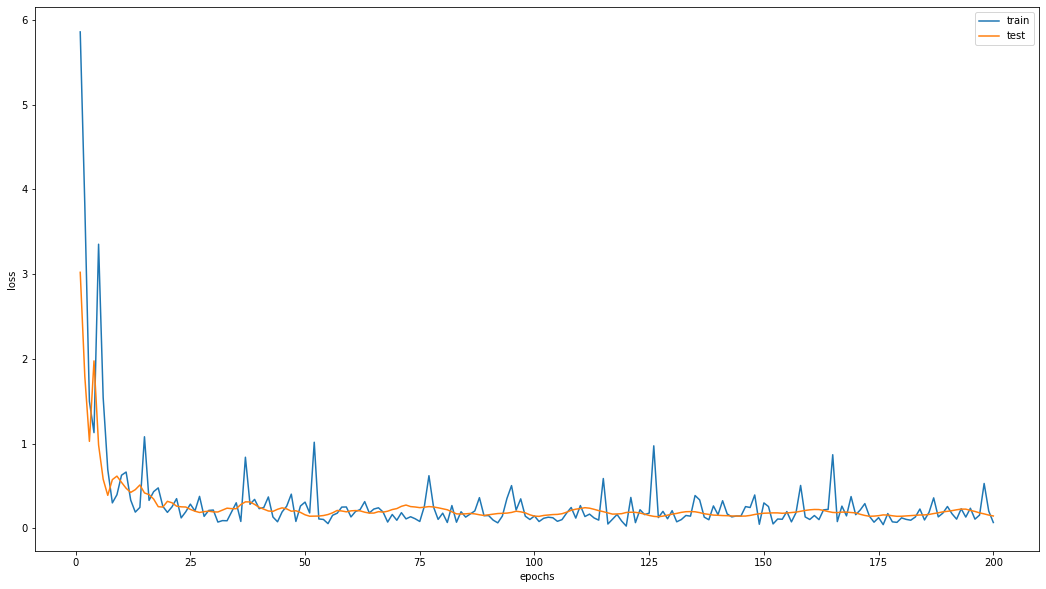

In [19]:
plt.plot(test_e,train_l,label='train')
plt.plot(test_e,test_l,label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [21]:
#Kod służący do sprawdzenia wyników z zbiorem testowym a prognozą modelu
to_pred=df_test['Postprocessed_raw']
predicted_val=[]
#prognozowanie
for im in to_pred:
    img_to_pred=cv2.imread('C:/Users/komej/Desktop/AutoEnhancer/'+im)
    #img_to_pred=tf.keras.applications.resnet_v2.preprocess_input(img_to_pred)
    img_to_pred=preprocess_input(img_to_pred)/127.5
    img_to_pred=np.expand_dims(img_to_pred,axis=0)
    score=model.predict(img_to_pred)
    predicted_val.append(np.array(score)[:,:,0])
#Zaokrąglanie wartości aby były takie same
predicted_val=np.array(predicted_val)[:,:,0]
#predicted_val=np.transpose(predicted_val,axes=(1,0))
predicted_val[0]=np.round_(predicted_val[0],1)
predicted_val[1]=np.round_(predicted_val[1],1)
predicted_val[2:10]=np.round_(predicted_val[2:10],2)
predicted_val[10]=np.round_(predicted_val[10],2)
predicted_val[11:]=np.round_(predicted_val[11:],2)

In [22]:
#rezultat z modelu
predicted_val

array([[-0.  ,  0.1 ,  0.1 ,  0.1 ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.7 ,
         0.3 ,  0.  ,  0.3 ,  0.1 ,  0.1 ],
       [-0.  ,  0.1 ,  0.1 ,  0.1 ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.7 ,
         0.3 ,  0.  ,  0.3 ,  0.1 ,  0.1 ],
       [-0.02,  0.05,  0.09,  0.14,  0.04,  0.06,  0.04,  0.04,  0.68,
         0.35,  0.03,  0.28,  0.1 ,  0.12],
       [-0.02,  0.05,  0.09,  0.13,  0.04,  0.06,  0.04,  0.05,  0.68,
         0.34,  0.02,  0.27,  0.1 ,  0.12],
       [-0.01,  0.04,  0.1 ,  0.12,  0.04,  0.05,  0.04,  0.05,  0.66,
         0.33, -0.  ,  0.26,  0.1 ,  0.12],
       [-0.02,  0.05,  0.1 ,  0.12,  0.04,  0.05,  0.04,  0.05,  0.67,
         0.34,  0.  ,  0.26,  0.1 ,  0.12],
       [-0.02,  0.05,  0.09,  0.14,  0.04,  0.06,  0.04,  0.04,  0.68,
         0.34,  0.03,  0.28,  0.1 ,  0.12],
       [-0.02,  0.05,  0.1 ,  0.13,  0.04,  0.06,  0.04,  0.04,  0.68,
         0.34,  0.02,  0.28,  0.1 ,  0.12],
       [-0.02,  0.05,  0.1 ,  0.12,  0.04,  0.05,  0.04,  0.04,  0.67,
         

In [23]:
#prawdziwe etykiety
labels_test

array([[ 0.  , -0.1 ,  0.12,  0.06,  0.03,  0.  ,  0.05,  0.  ,  0.61,
         0.3 ,  0.  ,  0.2 ,  0.1 ,  0.05],
       [ 0.1 ,  0.  ,  0.1 ,  0.08,  0.04,  0.  ,  0.06,  0.  ,  0.6 ,
         0.3 , -0.1 ,  0.1 ,  0.05,  0.09],
       [ 0.  ,  0.  ,  0.02,  0.04,  0.  ,  0.11,  0.1 ,  0.05,  0.64,
         0.2 ,  0.1 ,  0.17,  0.1 ,  0.02],
       [ 0.  ,  0.  ,  0.02,  0.05,  0.03,  0.1 ,  0.1 ,  0.3 ,  0.65,
         0.1 ,  0.2 ,  0.15,  0.05,  0.08],
       [ 0.  ,  0.  ,  0.13,  0.1 ,  0.06,  0.1 ,  0.05,  0.05,  0.66,
         0.2 ,  0.1 ,  0.19,  0.05,  0.1 ],
       [ 0.  ,  0.  ,  0.03,  0.08,  0.05,  0.07,  0.03,  0.  ,  0.63,
         0.2 ,  0.1 ,  0.1 ,  0.05,  0.08],
       [ 0.  ,  0.  ,  0.  ,  0.05,  0.  ,  0.12,  0.06,  0.07,  0.64,
         0.1 ,  0.1 ,  0.15,  0.05,  0.05],
       [ 0.  ,  0.  ,  0.03,  0.07,  0.03,  0.1 ,  0.09,  0.23,  0.65,
         0.2 ,  0.2 ,  0.12,  0.05,  0.1 ],
       [ 0.  ,  0.  ,  0.05,  0.09,  0.03,  0.08,  0.04,  0.03,  0.66,
         

In [57]:
print('Średnia dla etykiet:',np.mean(labels_test),'Średnia dla wyników:',np.mean(predicted_val))

Średnia dla etykiet: 0.11664835164835168 Średnia dla wyników: 0.13824175


In [56]:
print('Odchylenie Standardowe dla etykiet:',np.std(labels_test),'Odchylenie Standardowe dla wyników:',np.std(predicted_val))

Odchylenie Standardowe dla etykiet: 0.16306904582438123 Odchylenie Standardowe dla wyników: 0.17663269


In [55]:
#Błąd średniokwadratowy na zbiorze testowym
mse_eval=tf.keras.metrics.mean_squared_error(np.transpose(labels_test,(1,0)),np.transpose(predicted_val,(1,0))).numpy()
print('Whites:',mse_eval[0]*10)
print('Blacks:',mse_eval[1]*10)
print('Exposure:',mse_eval[2])
print('Gamma:',mse_eval[3])
print('Shadows:',mse_eval[4])
print('Higlights:',mse_eval[5])
print('Contrast:',mse_eval[6])
print('Dehaze:',mse_eval[7])
print('Temperature:',mse_eval[8]*10000)
print('Saturation:',mse_eval[9]*10)
print('Tint:',mse_eval[10]*10)
print('Denoise:',mse_eval[11])
print('Color_denoise:',mse_eval[12])
print('Sharpen:',mse_eval[13])

Whites: 0.010846153600141406
Blacks: 0.05684616044163704
Exposure: 0.0042846156
Gamma: 0.0036615385
Shadows: 0.00076153845
Higlights: 0.0027461539
Contrast: 0.0025846155
Dehaze: 0.014161538
Temperature: 20.230766385793686
Saturation: 0.2650769427418709
Tint: 0.19676923751831055
Denoise: 0.01646923
Color_denoise: 0.0021153847
Sharpen: 0.0029999998


In [35]:
#Sortowanie od największego
print(np.sort(mse_eval)[::-1])

[0.02650769 0.01967692 0.01646923 0.01416154 0.00568462 0.00428462
 0.00366154 0.003      0.00274615 0.00258462 0.00211538 0.00202308
 0.00108462 0.00076154]


In [36]:
#Sortowanie od najmniejszego
print(np.sort(mse_eval))

[0.00076154 0.00108462 0.00202308 0.00211538 0.00258462 0.00274615
 0.003      0.00366154 0.00428462 0.00568462 0.01416154 0.01646923
 0.01967692 0.02650769]


In [54]:
#Średni błąd bezwzględny na zbiorze testowym
mae_eval=tf.keras.metrics.mean_absolute_error(np.transpose(labels_test,(1,0)),np.transpose(predicted_val,(1,0))).numpy()
print('Whites:',mae_eval[0]*10)
print('Blacks:',mae_eval[1]*10)
print('Exposure:',mae_eval[2])
print('Gamma:',mae_eval[3])
print('Shadows:',mae_eval[4])
print('Higlights:',mae_eval[5])
print('Contrast:',mae_eval[6])
print('Dehaze:',mae_eval[7])
print('Temperature:',mae_eval[8]*10000)
print('Saturation:',mae_eval[9]*10)
print('Tint:',mae_eval[10]*10)
print('Denoise:',mae_eval[11])
print('Color_denoise:',mae_eval[12])
print('Sharpen:',mae_eval[13])

Whites: 0.23846153169870377
Blacks: 0.623076967895031
Exposure: 0.05923077
Gamma: 0.053846154
Shadows: 0.023846153
Higlights: 0.043846156
Contrast: 0.044615388
Dehaze: 0.07307692
Temperature: 346.1539000272751
Saturation: 1.4000000059604645
Tint: 1.1999999731779099
Denoise: 0.12384614
Color_denoise: 0.042307694
Sharpen: 0.047692303


In [58]:
#Sortowanie od największego
print(np.sort(mae_eval)[::-1])

[0.14       0.12384614 0.12       0.07307692 0.0623077  0.05923077
 0.05384615 0.0476923  0.04461539 0.04384616 0.04230769 0.03461539
 0.02384615 0.02384615]


In [59]:
#Sortowanie od najmniejszego
print(np.sort(mae_eval))

[0.02384615 0.02384615 0.03461539 0.04230769 0.04384616 0.04461539
 0.0476923  0.05384615 0.05923077 0.0623077  0.07307692 0.12
 0.12384614 0.14      ]


Na porównaniu widać że wartości są całkiem sprawnie dobierane, chociaż jest to dosyć trudne zadanie ze względu na bardzo dużą różnorodność oraz zmienne wymiary danych wejściowych. Model najgorzej sobie radzi z doborem nasycenia kolorów, odcienia i odszumiania. Zaś najlepiej z doborem białych, cieni oraz świateł. porównania graficznie w innym pliku.

In [42]:
model.save('C:/Users/komej/Desktop/AutoEnhancer/enh7-seg.h5')